# Example of upper limit computation.

In [1]:
from statnight import Hypothesis, Observable, Model, Constant, Variable
from statnight.calculators import AsymptoticCalculator
from statnight.utils.pdf import Gaussian, gaussian, exponential
from scipy.stats import expon
from statnight.utils.stats import integrate1d
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import math

## Scenario

Let's assume you want to find a resonnance between 0.1 and 3.0 GeV/c$^2$ of invariant mass of a system.

You have a signal region and a background only region:

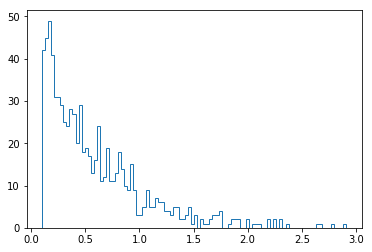

In [2]:
bounds = (0.1,3.0)

#background only
np.random.seed(10)
tau = 2.0
beta = 1./tau
data = np.random.exponential(beta, 1000)

data_bkg = data[(data > bounds[0]) & (data < bounds[1])]
plt.hist(data_bkg, bins=100, histtype='step');

In [3]:
#signal + background

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 4)
data = np.concatenate((data,peak))
data = data[(data > 0.1) & (data < 3)]

### Background fit, in background only region:

The background model is an exponential.

In [4]:
#NBVAL_CHECK_OUTPUT
def exp_normalized(x, tau):
    ret = exponential(x, tau)
    norm = exponential.integrate(bounds, 100, tau)
    return ret/norm

model_bkg = Model(exp_normalized)
model_bkg.add_obs(Observable("x", range = bounds))
tau = Variable("tau",   range=(0.1, 5.0), initvalue=0.5,       initstep=0.05)
model_bkg.add_vars(tau)

lh_bkg = model_bkg.nll_function(data_bkg)

params = tau.tominuit()

minuit_bkg = iminuit.Minuit(lh_bkg, pedantic=True, errordef=0.5, **params)

In [5]:
minuit_bkg.migrad();

FCN = 222.3887194852312 
 TOTAL NCALL = 25 
 NCALLS = 25 
 
 
 EDM = 1.488886290787599e-10 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,tau,2.02224,0.0750417,,,0.1,5,No


### Signal + background fit in signal region:

The total model is a sum of a gaussian and an exponential. The tau parameter of the exponential will be constrained to the value obtained in the background only region.

In [6]:
def gauss_normalized(x, mu, sigma):  
    ret = gaussian(x, mu, sigma)
    norm = gaussian.integrate(bounds, 100, mu, sigma)
    return ret/ norm

def exp_extended(x, tau, Nbkg):  
    ret = exp_normalized(x, tau)
    return ret * Nbkg

def gauss_extended(x, mu, sigma, Nsig):  
    ret = gauss_normalized(x, mu, sigma)
    return ret * Nsig

def totpdf(x, mu, sigma, Nsig, tau, Nbkg):
    ret  = gauss_extended(x, mu, sigma, Nsig)
    ret += exp_extended(x, tau, Nbkg)
    return ret

#### Model definition:

Construct a model from a given probability density function (pdf) and then assign which parameters of the pdf are observables or variables/constants and initialize them.

Observable and Variable require a name and a range. Optional arguments can be given to Variable such as an initial value and initial step for minuit, and constraint wich is a function.
Constant only require a name and a value.

In [7]:
model_sb = Model(totpdf)

model_sb.add_obs(Observable("x", range = bounds))

mean  = Constant("mu",  value=1.2)
sigma = Constant("sigma", value= 0.1)
Nsig  = Variable("Nsig",  range=(-10,len((data))),   initvalue= 0.0,       initstep=1.0)
tau_constraint = Gaussian(mean = minuit_bkg.values["tau"], sigma = minuit_bkg.errors["tau"])
tau   = Variable("tau",   range=(0.1, 5.0), initvalue=0.5, initstep=0.05, constraint=tau_constraint)
Nbkg  = Variable("Nbkg",  range=(0,len((data))*1.1), initvalue= len(data), initstep=1.0)

model_sb.add_vars([mean, sigma, Nsig, tau, Nbkg])

model_sb.add_ext_pars(["Nsig","Nbkg"])

In [8]:
model_sb.variables

[Constant('mu', value=1.2),
 Constant('sigma', value=0.1),
 Variable('Nsig', initvalue=0.0, range=(-10, 250), initstep=1.0),
 Variable('tau', initvalue=0.5, range=(0.1, 5.0), initstep=0.05, constraint=<statnight.utils.pdf.Gaussian object at 0x11405d630>),
 Variable('Nbkg', initvalue=250, range=(0, 275.0), initstep=1.0)]

In [9]:
lh_sb = model_sb.nll_function(data)

params = {}
for v in model_sb.variables:
    params.update(v.tominuit())

minuit_sb = iminuit.Minuit(lh_sb, pedantic=True, errordef=0.5, **params)

In [10]:
minuit_sb.migrad();

FCN = -1053.7124336563477 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 4.0515362320869285e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,1.2,1,,,,,Yes
1,sigma,0.1,1,,,,,Yes
2,Nsig,-0.613242,4.75214,,,-10,250,No
3,tau,2.00075,0.0665911,,,0.1,5,No
4,Nbkg,250.699,16.4366,,,0,275,No


In [11]:
def plotfitresult(pdf, bounds, nbins, *args):
    x = np.linspace(bounds[0], bounds[1], nbins)
    bin_centers = x[:-1] + np.diff(x)/2.
    y = np.zeros(bin_centers.shape)
    
    for i in range(nbins-1):
        y[i] = integrate1d(pdf, (x[i],x[i+1]), 100, *args)
        
    plt.plot(bin_centers, y, "-r")      

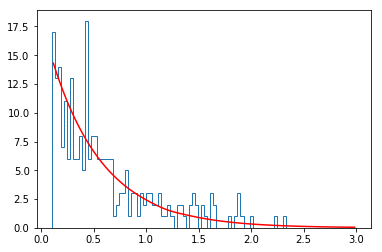

In [12]:
nbins = 100
fit_result = minuit_sb.values.values()
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(totpdf, bounds, nbins, *fit_result)

The number of signal events is consistent with zero, let's compute now an upper limit for this model.

## Upper limit:

In [13]:
null_hypothesis = model_sb.create_hypothesis({"Nsig":np.linspace(0.1, 12, 60)})
null_hypothesis.summary()

Observables: ['x']
Paramaters of interest: {'Nsig': array([ 0.1       ,  0.30169492,  0.50338983,  0.70508475,  0.90677966,
        1.10847458,  1.31016949,  1.51186441,  1.71355932,  1.91525424,
        2.11694915,  2.31864407,  2.52033898,  2.7220339 ,  2.92372881,
        3.12542373,  3.32711864,  3.52881356,  3.73050847,  3.93220339,
        4.13389831,  4.33559322,  4.53728814,  4.73898305,  4.94067797,
        5.14237288,  5.3440678 ,  5.54576271,  5.74745763,  5.94915254,
        6.15084746,  6.35254237,  6.55423729,  6.7559322 ,  6.95762712,
        7.15932203,  7.36101695,  7.56271186,  7.76440678,  7.96610169,
        8.16779661,  8.36949153,  8.57118644,  8.77288136,  8.97457627,
        9.17627119,  9.3779661 ,  9.57966102,  9.78135593,  9.98305085,
       10.18474576, 10.38644068, 10.58813559, 10.78983051, 10.99152542,
       11.19322034, 11.39491525, 11.59661017, 11.79830508, 12.        ])}
Nuisance parameters: ['mu', 'sigma', 'tau', 'Nbkg']
Extended parameters: ['Nsig', 

In [14]:
alt_hypothesis = model_sb.create_hypothesis({"Nsig":0})
alt_hypothesis.summary()

Observables: ['x']
Paramaters of interest: {'Nsig': 0}
Nuisance parameters: ['mu', 'sigma', 'tau', 'Nbkg']
Extended parameters: ['Nsig', 'Nbkg']



In [15]:
calc = AsymptoticCalculator(null_hypothesis, alt_hypothesis, data)
calc.qtilde = False
calc.CLs = True
calc.bestfitpoi = minuit_sb.values["Nsig"]

In [16]:
ul = calc.upperlimit()

Get fit best values for nuisance parameters for alternative hypothesis!


FCN = -1053.7051943528315 
 TOTAL NCALL = 40 
 NCALLS = 40 
 
 
 EDM = 4.441678646401136e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,1.2,1,,,,,Yes
1,sigma,0.1,1,,,,,Yes
2,Nsig,0,1,,,-10,250,Yes
3,tau,2.00254,0.0654241,,,0.1,5,No
4,Nbkg,249.999,15.7062,,,0,275,No


/usr/local/lib/python3.7/site-packages/statnight-1.0-py3.7.egg/statnight/calculators/asymptotic_calculator.py:293: RuntimeWarning: invalid value encountered in true_divide
  p_values["cls"] = p_values["clsb"] / p_values["clb"]


Observed upper limit: Nsig = 10.426994321808749
Expected upper limit: Nsig = 10.764430453196741
Expected upper limit +1 sigma: Nsig = 14.978127993382877
Expected upper limit -1 sigma: Nsig = 7.7548952907528665
Expected upper limit +2 sigma: Nsig = 20.079241075981603
Expected upper limit -2 sigma: Nsig = 5.776450205078546


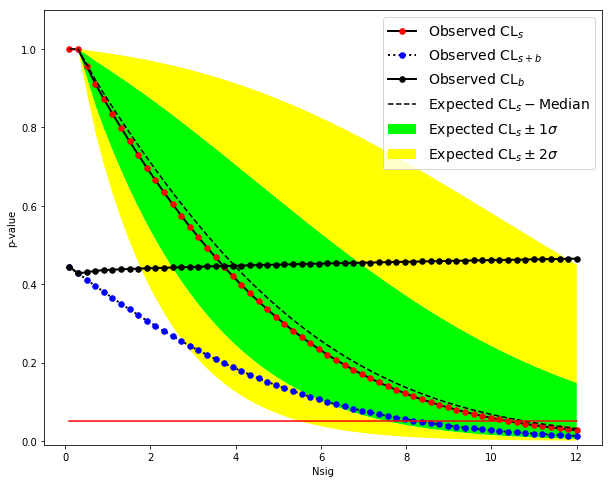

In [17]:
calc.plot()